This script implements functions for generating APT data signals and modulated APT baseband 2.4 kHz subcarrier signals

- source: NOAA KLM user's guide, Section 4.2: APT System
- www.ncdc.noaa.gov/oa/pod-guide/ncdc/docs/klm/html/c4/sec4-2.htm


- **TODO:** code the telemtry data to have the proper wedge values. 
- **TODO:** minute markers spaces should have a 2px 11 or 244 (whichever is inverted from the backgroud) line in them every minute

In [1]:
# this line makes the plots visilble in the jupyter notebook
%matplotlib inline

from __future__ import division
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import math
import random

"""
mul is a global variable that is used in the
generator functions in order to produce the correct
amout of data. Mul should be an interger value.

The final sample rate of the data is 2080 * mul

Considering that the data will be modulated with a 
"""
mul = 1

def syncA():
    data = mul*4*[11]
    # 7 1040 Hz 50% duty pulses
    for i in xrange(0,7):
        data += mul*2 * [244]
        data += mul*2*[11]
    data += mul*7 * [11]
    return data

def syncB():
    data = mul*4*[11]
    # 7  832 Hz 3/5 duty pulses
    for i in xrange(0,7):
        data += mul*3 * [244]
        data += mul*2*[11]
    return data

def markerA():
    return mul*47 * [11]
def markerB():
    return mul*47 * [244]


def videoA():
    """
    Note that since here are only 244-11=233 pixel values
    avilable, the quantisized gradient will have
    multiple consicutive pixels with the same value
    """
    data = 0*[0]
    for i in range(0,909):
        # dont use all of the dynamic range (-50)
        data += [int((i*(244-11-50))/(909) + 11+(50/2))] * mul
    return data
def videoB():
    """fills B channel with random data"""
    data = 0*[0]
    for i in range(0,909):
        data += [random.randint(100,140)] * mul
    return data

""" These still need some work: implement wedges"""
def telemetryA(value=128):
    return mul*45 * [value]
def telemetryB(value=128):
    return mul*45 * [value]


def line(telemetry=128):
    """organize all the parts of a line in the right order"""
    data = syncA()
    data += markerA()
    data += videoA()
    data += telemetryA(value=telemetry)
    data += syncB()
    data += markerB()
    data += videoB()
    data += telemetryB(value=telemetry)
    return data

def frame():
    """an APT frome is 128 lines high"""
    data = [0]*0
    
    # these have calimbration wedges
    for i in xrange(0,8): 
        for j in range(0,8):          
            data += line(telemetry=int(11 + (233/7) * i))
    # these have actual telemetry
    for i in xrange(0,64):
        data += line()
    return data

This next part show an example of how to use the
APT functions in a way that will work well with 
DSP techniques, and plot some visualizations of
what APT data looks like

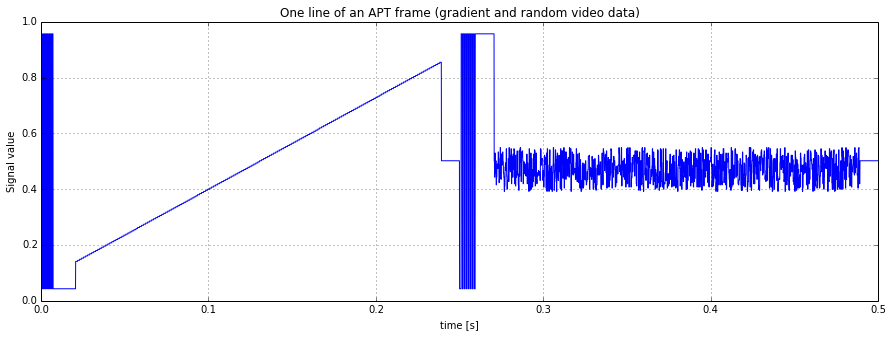

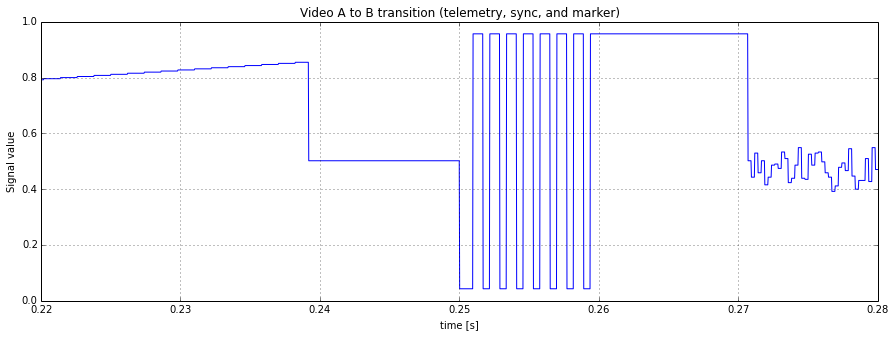

In [22]:

# make sure we will have plenty of samples
mul = 8
# convert from int space 0...256 to float space 0 ... 1.0
data = line()
data = [val /255 for val in data]

# plot agains eiher symbol index, or actual time
# idx =  np.linspace(0,len(data) -1 ,len(data))
time = np.linspace(0,0.5,len(data))

plt.figure(figsize=(15,5))
plt.grid()
plt.title("One line of an APT frame (gradient and random video data)")
plt.ylim(0, 1)
plt.xlabel("time [s]")
plt.ylabel("Signal value")
plt.plot(time, data)

plt.figure(figsize=(15,5))
plt.grid()
plt.title("Video A to B transition (telemetry, sync, and marker)")
plt.ylim(0, 1)
plt.xlim(0.22, 0.28)
plt.xlabel("time [s]")
plt.ylabel("Signal value")
plt.plot(time, data)

plt.show()


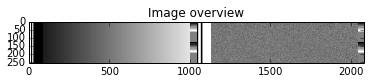

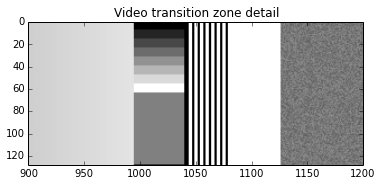

In [23]:
# data signal for creating a bitmap
mul = 1
image_data = np.reshape(frame()+frame(), (-1, 2080))

plt.figure()
plt.imshow(image_data, cmap="gray")
plt.title("Image overview")
plt.figure()
plt.title("Video transition zone detail")
plt.xlim(900,1200)
plt.ylim(128, 0)
plt.imshow(image_data, cmap="gray")
plt.show()

In [24]:
from scipy.io.wavfile import write

# make sure we will have plenty of samples
mul = 10
data = frame()
# convert from int space 0...256 to float space 0 ... 1.0
data = [val/255 for val in data]

# time axsis with actual seconds as unit
elapsed_time = len(data) / mul / 4160
time = np.linspace(0,elapsed_time,len(data))

# multiply data with 2400 Hz sine wave
modulated = np.multiply(np.sin([2*np.pi*2400*val for val in time]), data)

# wxtoimg wants uint16 samples
scaled = np.int16(modulated/np.max(np.abs(modulated)) * 32767)

# two lines a second, 2080 symbols per line, mul samples per symbol
write("/tmp/test.wav", 2*2080*mul, scaled)

In [7]:
mul = 2
data = [val/255 for val in line()]
time = np.linspace(0,len(data) / mul / 4160,len(data))
modulated = np.multiply(np.sin([2*np.pi*2400*val for val in time]), data)


plt.figure(figsize=(15,5))
plt.title("4 sample per symbol. Is this the effect of aliasing in time domain?")
plt.ylim(0, 1)
plt.xlim(0.22, 0.28)
plt.plot(time, modulated)

plt.show()